In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [8]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 5

In [9]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [10]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [11]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.1, 1000, 0.1)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 1000: PDE Error: 0.015240130640; False Transient Error: 0.015212242617; Iterations: 229; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.018259589174; False Transient Error: 0.018234238717; Iterations: 196; CG Error: 0.000000000092
Episode 1000: PDE Error: 0.023176381638; False Transient Error: 0.022788761588; Iterations: 247; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.030367611443; False Transient Error: 0.026099998403; Iterations: 246; CG Error: 0.000000000094
Episode 1000: PDE Error: 0.013991484089; False Transient Error: 0.013855860727; Iterations: 246; CG Error: 0.000000000092
Episode 1000: PDE Error: 0.013461686995; False Transient Error: 0.013431917378; Iterations: 243; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.025789565852; False Transient Error: 0.024234525774; Iterations: 246; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.028859585926; False Transient Error: 0.025512792166; Iterations: 246; CG Error: 0.000000000095
Episode 1000: PDE Error:

In [12]:
np.save(f"v_list_{λ}", ϕ_list)
np.save(f"e_list_{λ}", ems_list)

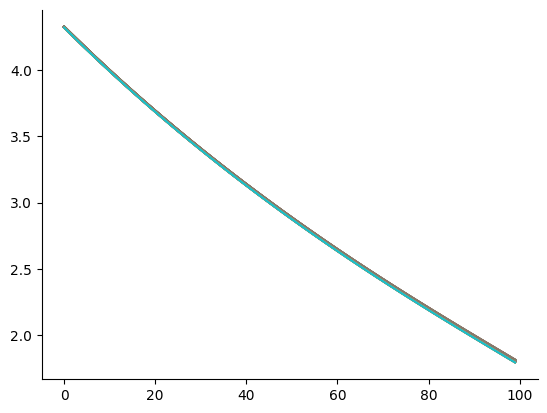

In [6]:
plt.plot(ϕ_list[0])
plt.show()

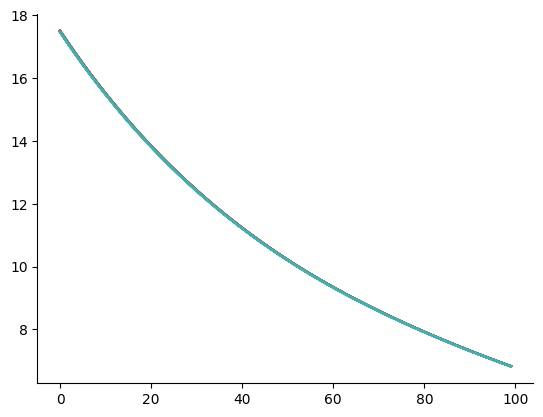

In [7]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [14]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.1
max_iter = 2000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.438208657651	 rhs error: 0.466052924787
Episode: 2	 lhs error: 0.415152810070	 rhs error: 0.433639662954
Episode: 3	 lhs error: 0.392576332030	 rhs error: 0.404601840278
Episode: 4	 lhs error: 0.371715630499	 rhs error: 0.379285663739
Episode: 5	 lhs error: 0.351858701512	 rhs error: 0.356858234392
Episode: 6	 lhs error: 0.333595122286	 rhs error: 0.336658151693
Episode: 7	 lhs error: 0.316145223414	 rhs error: 0.317849441571
Episode: 8	 lhs error: 0.299064575902	 rhs error: 0.300066216021
Episode: 9	 lhs error: 0.282764550404	 rhs error: 0.283553283571
Episode: 10	 lhs error: 0.266945587377	 rhs error: 0.267451979614
Episode: 11	 lhs error: 0.252053840373	 rhs error: 0.252109389287
Episode: 12	 lhs error: 0.237151661664	 rhs error: 0.237243146651
Episode: 13	 lhs error: 0.222919906645	 rhs error: 0.222982152004
Episode: 14	 lhs error: 0.209253092019	 rhs error: 0.209501447532
Episode: 15	 lhs error: 0.196648074288	 rhs error: 0.196479044949
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.057013326714	 rhs error: 0.785449211828
Episode: 126	 lhs error: 0.034886019365	 rhs error: 0.645102497842
Episode: 127	 lhs error: 0.034781530978	 rhs error: 0.448277183913
Episode: 128	 lhs error: 0.034690043839	 rhs error: 0.285883263002
Episode: 129	 lhs error: 0.034572016369	 rhs error: 0.187355335653
Episode: 130	 lhs error: 0.034468559912	 rhs error: 0.133653646300
Episode: 131	 lhs error: 0.034363500510	 rhs error: 0.106660861874
Episode: 132	 lhs error: 0.034273517200	 rhs error: 0.105380297666
Episode: 133	 lhs error: 0.034154836112	 rhs error: 0.105743718218
Episode: 134	 lhs error: 0.034043107151	 rhs error: 0.106074082374
Episode: 135	 lhs error: 0.033925116883	 rhs error: 0.106445232928
Episode: 136	 lhs error: 0.033814555883	 rhs error: 0.106766487126
Episode: 137	 lhs error: 0.033701017875	 rhs error: 0.107083624609
Episode: 138	 lhs error: 0.033507503301	 rhs error: 0.107405960700
Episode: 139	 lhs error: 0.033411682673	 rhs error: 0.10773275

Episode: 249	 lhs error: 0.023425932919	 rhs error: 0.110246634150
Episode: 250	 lhs error: 0.023399736657	 rhs error: 0.110217600451
Episode: 251	 lhs error: 0.023372428251	 rhs error: 0.110176457744
Episode: 252	 lhs error: 0.023352478297	 rhs error: 0.110127872664
Episode: 253	 lhs error: 0.023314897527	 rhs error: 0.110041785232
Episode: 254	 lhs error: 0.023298122947	 rhs error: 0.109986836884
Episode: 255	 lhs error: 0.023277384033	 rhs error: 0.109867988933
Episode: 256	 lhs error: 0.023255577341	 rhs error: 0.109788322460
Episode: 257	 lhs error: 0.023217137267	 rhs error: 0.109654108315
Episode: 258	 lhs error: 0.023177369558	 rhs error: 0.109558295045
Episode: 259	 lhs error: 0.023142301401	 rhs error: 0.109424349733
Episode: 260	 lhs error: 0.023104659897	 rhs error: 0.109287999106
Episode: 261	 lhs error: 0.023068284691	 rhs error: 0.109142984514
Episode: 262	 lhs error: 0.023025303183	 rhs error: 0.108981265275
Episode: 263	 lhs error: 0.023005476276	 rhs error: 0.10881782

Episode: 373	 lhs error: 0.018005943759	 rhs error: 0.057324315765
Episode: 374	 lhs error: 0.017986580029	 rhs error: 0.056853881225
Episode: 375	 lhs error: 0.017966562910	 rhs error: 0.056387149161
Episode: 376	 lhs error: 0.017957293164	 rhs error: 0.055920093476
Episode: 377	 lhs error: 0.017925894126	 rhs error: 0.055437626690
Episode: 378	 lhs error: 0.017901908991	 rhs error: 0.054991898061
Episode: 379	 lhs error: 0.017877499926	 rhs error: 0.054542600216
Episode: 380	 lhs error: 0.017854976188	 rhs error: 0.054100057753
Episode: 381	 lhs error: 0.017831690287	 rhs error: 0.053659193500
Episode: 382	 lhs error: 0.017804425401	 rhs error: 0.053221002975
Episode: 383	 lhs error: 0.017779371212	 rhs error: 0.052779889358
Episode: 384	 lhs error: 0.017737175863	 rhs error: 0.052349830421
Episode: 385	 lhs error: 0.017728501121	 rhs error: 0.051924409382
Episode: 386	 lhs error: 0.017714644618	 rhs error: 0.051497652170
Episode: 387	 lhs error: 0.017677057553	 rhs error: 0.05106907

Episode: 497	 lhs error: 0.014463329985	 rhs error: 0.026521200143
Episode: 498	 lhs error: 0.014436786415	 rhs error: 0.026511638112
Episode: 499	 lhs error: 0.014416504063	 rhs error: 0.026371145398
Episode: 500	 lhs error: 0.014394178733	 rhs error: 0.026447338051
Episode: 501	 lhs error: 0.014370345881	 rhs error: 0.026486444714
Episode: 502	 lhs error: 0.014346327430	 rhs error: 0.026475277252
Episode: 503	 lhs error: 0.014321961190	 rhs error: 0.026476115695
Episode: 504	 lhs error: 0.014294908835	 rhs error: 0.026473046491
Episode: 505	 lhs error: 0.014274012364	 rhs error: 0.026477687511
Episode: 506	 lhs error: 0.014246451588	 rhs error: 0.026435385825
Episode: 507	 lhs error: 0.014217728032	 rhs error: 0.026472149462
Episode: 508	 lhs error: 0.014190287113	 rhs error: 0.026472816357
Episode: 509	 lhs error: 0.014163509438	 rhs error: 0.026469194770
Episode: 510	 lhs error: 0.014138024615	 rhs error: 0.026470442735
Episode: 511	 lhs error: 0.014111804695	 rhs error: 0.02645592

Episode: 621	 lhs error: 0.011800874737	 rhs error: 0.025952037643
Episode: 622	 lhs error: 0.011785883578	 rhs error: 0.025961633542
Episode: 623	 lhs error: 0.011771182232	 rhs error: 0.025966184208
Episode: 624	 lhs error: 0.011755586045	 rhs error: 0.025966893644
Episode: 625	 lhs error: 0.011740275322	 rhs error: 0.025966462794
Episode: 626	 lhs error: 0.011725650402	 rhs error: 0.025967885270
Episode: 627	 lhs error: 0.011710969597	 rhs error: 0.025964738941
Episode: 628	 lhs error: 0.011695253058	 rhs error: 0.025962178831
Episode: 629	 lhs error: 0.011679515275	 rhs error: 0.025961444125
Episode: 630	 lhs error: 0.011663391359	 rhs error: 0.025962172546
Episode: 631	 lhs error: 0.011646933355	 rhs error: 0.025963573887
Episode: 632	 lhs error: 0.011631643182	 rhs error: 0.025963950652
Episode: 633	 lhs error: 0.011615918014	 rhs error: 0.025956728417
Episode: 634	 lhs error: 0.011598937571	 rhs error: 0.025951369150
Episode: 635	 lhs error: 0.011581727959	 rhs error: 0.02595344

Episode: 745	 lhs error: 0.009825850262	 rhs error: 0.025960223993
Episode: 746	 lhs error: 0.009814490696	 rhs error: 0.025960184581
Episode: 747	 lhs error: 0.009802941200	 rhs error: 0.025959787400
Episode: 748	 lhs error: 0.009791202068	 rhs error: 0.025959611990
Episode: 749	 lhs error: 0.009779273206	 rhs error: 0.025959289789
Episode: 750	 lhs error: 0.009767160783	 rhs error: 0.025959492005
Episode: 751	 lhs error: 0.009754850620	 rhs error: 0.025959414643
Episode: 752	 lhs error: 0.009742353276	 rhs error: 0.025959361581
Episode: 753	 lhs error: 0.009729672653	 rhs error: 0.025959815055
Episode: 754	 lhs error: 0.009716795351	 rhs error: 0.025959690287
Episode: 755	 lhs error: 0.009703727003	 rhs error: 0.025960105702
Episode: 756	 lhs error: 0.009690459363	 rhs error: 0.025959591812
Episode: 757	 lhs error: 0.009677015660	 rhs error: 0.025960081335
Episode: 758	 lhs error: 0.009663381661	 rhs error: 0.025960398608
Episode: 759	 lhs error: 0.009649569690	 rhs error: 0.02596121

Episode: 869	 lhs error: 0.008286246636	 rhs error: 0.025968235432
Episode: 870	 lhs error: 0.008274578973	 rhs error: 0.025966990620
Episode: 871	 lhs error: 0.008262752966	 rhs error: 0.025965884379
Episode: 872	 lhs error: 0.008250757440	 rhs error: 0.025964628184
Episode: 873	 lhs error: 0.008238601223	 rhs error: 0.025963472452
Episode: 874	 lhs error: 0.008226275180	 rhs error: 0.025962287433
Episode: 875	 lhs error: 0.008213809354	 rhs error: 0.025961450113
Episode: 876	 lhs error: 0.008201209330	 rhs error: 0.025961425649
Episode: 877	 lhs error: 0.008188457779	 rhs error: 0.025961689336
Episode: 878	 lhs error: 0.008175586373	 rhs error: 0.025961608492
Episode: 879	 lhs error: 0.008162568743	 rhs error: 0.025961162281
Episode: 880	 lhs error: 0.008149400131	 rhs error: 0.025960384140
Episode: 881	 lhs error: 0.008136086256	 rhs error: 0.025959457301
Episode: 882	 lhs error: 0.008122598576	 rhs error: 0.025958686080
Episode: 883	 lhs error: 0.008109599491	 rhs error: 0.02595779

Episode: 993	 lhs error: 0.007042261652	 rhs error: 0.025894654179
Episode: 994	 lhs error: 0.007033551509	 rhs error: 0.025894721499
Episode: 995	 lhs error: 0.007013201449	 rhs error: 0.025892965843
Episode: 996	 lhs error: 0.007012541857	 rhs error: 0.025961274430
Episode: 997	 lhs error: 0.006997618865	 rhs error: 0.025940156588
Episode: 998	 lhs error: 0.006982961565	 rhs error: 0.025954743450
Episode: 999	 lhs error: 0.006984087942	 rhs error: 0.025984790907
Episode: 1000	 lhs error: 0.006977589456	 rhs error: 0.025926050772
Episode: 1001	 lhs error: 0.006968712908	 rhs error: 0.025926241979
Episode: 1002	 lhs error: 0.006959108829	 rhs error: 0.025924022545
Episode: 1003	 lhs error: 0.006949413626	 rhs error: 0.025924227813
Episode: 1004	 lhs error: 0.006933302398	 rhs error: 0.025917752449
Episode: 1005	 lhs error: 0.006926254761	 rhs error: 0.025742126347
Episode: 1006	 lhs error: 0.006916619147	 rhs error: 0.025876947523
Episode: 1007	 lhs error: 0.006892338574	 rhs error: 0.

Episode: 1117	 lhs error: 0.006018602109	 rhs error: 0.025993922607
Episode: 1118	 lhs error: 0.006001108206	 rhs error: 0.025958233000
Episode: 1119	 lhs error: 0.005998101538	 rhs error: 0.026025268355
Episode: 1120	 lhs error: 0.005987913771	 rhs error: 0.025991317143
Episode: 1121	 lhs error: 0.005981854934	 rhs error: 0.026006275373
Episode: 1122	 lhs error: 0.005973132092	 rhs error: 0.025989861575
Episode: 1123	 lhs error: 0.005964541426	 rhs error: 0.025991258016
Episode: 1124	 lhs error: 0.005955657944	 rhs error: 0.025991970834
Episode: 1125	 lhs error: 0.005947796545	 rhs error: 0.025995213924
Episode: 1126	 lhs error: 0.005938662044	 rhs error: 0.025990975197
Episode: 1127	 lhs error: 0.005932907512	 rhs error: 0.025993755237
Episode: 1128	 lhs error: 0.005926964688	 rhs error: 0.025992747138
Episode: 1129	 lhs error: 0.005920740562	 rhs error: 0.025992426646
Episode: 1130	 lhs error: 0.005914560667	 rhs error: 0.025992223658
Episode: 1131	 lhs error: 0.005908204580	 rhs er

Episode: 1241	 lhs error: 0.005170242019	 rhs error: 0.025976942025
Episode: 1242	 lhs error: 0.005164093785	 rhs error: 0.025978178622
Episode: 1243	 lhs error: 0.005158054984	 rhs error: 0.025979129979
Episode: 1244	 lhs error: 0.005151963162	 rhs error: 0.025980349890
Episode: 1245	 lhs error: 0.005145671306	 rhs error: 0.025981379668
Episode: 1246	 lhs error: 0.005139488688	 rhs error: 0.025981908453
Episode: 1247	 lhs error: 0.005133251304	 rhs error: 0.025982416929
Episode: 1248	 lhs error: 0.005126633341	 rhs error: 0.025983185686
Episode: 1249	 lhs error: 0.005120248934	 rhs error: 0.025982662345
Episode: 1250	 lhs error: 0.005113694029	 rhs error: 0.025983118607
Episode: 1251	 lhs error: 0.005106935277	 rhs error: 0.025983117966
Episode: 1252	 lhs error: 0.005100394930	 rhs error: 0.025982632371
Episode: 1253	 lhs error: 0.005093779504	 rhs error: 0.025983095831
Episode: 1254	 lhs error: 0.005086955258	 rhs error: 0.025983632500
Episode: 1255	 lhs error: 0.005080763710	 rhs er

Episode: 1365	 lhs error: 0.004460268337	 rhs error: 0.025972838557
Episode: 1366	 lhs error: 0.004454956430	 rhs error: 0.025973304730
Episode: 1367	 lhs error: 0.004449620167	 rhs error: 0.025973605406
Episode: 1368	 lhs error: 0.004444180246	 rhs error: 0.025974211502
Episode: 1369	 lhs error: 0.004438421855	 rhs error: 0.025974967340
Episode: 1370	 lhs error: 0.004432951181	 rhs error: 0.025975854994
Episode: 1371	 lhs error: 0.004428000780	 rhs error: 0.025977004117
Episode: 1372	 lhs error: 0.004422815412	 rhs error: 0.025978435956
Episode: 1373	 lhs error: 0.004417707313	 rhs error: 0.025979993407
Episode: 1374	 lhs error: 0.004412789091	 rhs error: 0.025981597367
Episode: 1375	 lhs error: 0.004407940599	 rhs error: 0.025983002564
Episode: 1376	 lhs error: 0.004403204008	 rhs error: 0.025984205130
Episode: 1377	 lhs error: 0.004398496053	 rhs error: 0.025985119687
Episode: 1378	 lhs error: 0.004393572923	 rhs error: 0.025985869278
Episode: 1379	 lhs error: 0.004395057300	 rhs er

Episode: 1489	 lhs error: 0.003857925371	 rhs error: 0.025970269784
Episode: 1490	 lhs error: 0.003853216638	 rhs error: 0.025969059878
Episode: 1491	 lhs error: 0.003848175011	 rhs error: 0.025967402601
Episode: 1492	 lhs error: 0.003844086001	 rhs error: 0.025966018173
Episode: 1493	 lhs error: 0.003839051065	 rhs error: 0.025964363491
Episode: 1494	 lhs error: 0.003834411173	 rhs error: 0.025963153142
Episode: 1495	 lhs error: 0.003830113520	 rhs error: 0.025961671811
Episode: 1496	 lhs error: 0.003826042595	 rhs error: 0.025960414811
Episode: 1497	 lhs error: 0.003822005090	 rhs error: 0.025959241324
Episode: 1498	 lhs error: 0.003817800696	 rhs error: 0.025959058924
Episode: 1499	 lhs error: 0.003813471917	 rhs error: 0.025959812972
Episode: 1500	 lhs error: 0.003808950293	 rhs error: 0.025961800251
Episode: 1501	 lhs error: 0.003805126591	 rhs error: 0.025965191176
Episode: 1502	 lhs error: 0.003800996381	 rhs error: 0.025968633786
Episode: 1503	 lhs error: 0.003797553551	 rhs er

Episode: 1613	 lhs error: 0.002897947631	 rhs error: 0.025981450344
Episode: 1614	 lhs error: 0.002887102111	 rhs error: 0.025981374076
Episode: 1615	 lhs error: 0.002876302075	 rhs error: 0.025981100331
Episode: 1616	 lhs error: 0.002865859609	 rhs error: 0.025980973510
Episode: 1617	 lhs error: 0.002855380932	 rhs error: 0.025980237184
Episode: 1618	 lhs error: 0.002845043119	 rhs error: 0.025979620158
Episode: 1619	 lhs error: 0.002834741957	 rhs error: 0.025978838104
Episode: 1620	 lhs error: 0.002824419826	 rhs error: 0.025978018395
Episode: 1621	 lhs error: 0.002814071105	 rhs error: 0.025977164416
Episode: 1622	 lhs error: 0.002803658267	 rhs error: 0.025976336441
Episode: 1623	 lhs error: 0.002793171418	 rhs error: 0.025975603578
Episode: 1624	 lhs error: 0.002782613682	 rhs error: 0.025974979994
Episode: 1625	 lhs error: 0.002772032703	 rhs error: 0.025974434625
Episode: 1626	 lhs error: 0.002761386379	 rhs error: 0.025973822909
Episode: 1627	 lhs error: 0.002750701249	 rhs er

Episode: 1737	 lhs error: 0.001541991276	 rhs error: 0.025928472792
Episode: 1738	 lhs error: 0.001530901127	 rhs error: 0.025956164697
Episode: 1739	 lhs error: 0.001518340951	 rhs error: 0.025922707649
Episode: 1740	 lhs error: 0.001534526255	 rhs error: 0.025961038179
Episode: 1741	 lhs error: 0.001412019071	 rhs error: 0.025952615813
Episode: 1742	 lhs error: 0.001555471381	 rhs error: 0.025873876375
Episode: 1743	 lhs error: 0.001480064537	 rhs error: 0.025959207860
Episode: 1744	 lhs error: 0.001456680748	 rhs error: 0.025969737556
Episode: 1745	 lhs error: 0.001452583441	 rhs error: 0.025984129978
Episode: 1746	 lhs error: 0.001446835305	 rhs error: 0.025982290366
Episode: 1747	 lhs error: 0.001542203476	 rhs error: 0.025972011153
Episode: 1748	 lhs error: 0.001449639314	 rhs error: 0.025948661038
Episode: 1749	 lhs error: 0.001414339232	 rhs error: 0.025938877782
Episode: 1750	 lhs error: 0.001388398972	 rhs error: 0.025924739810
Episode: 1751	 lhs error: 0.001389388145	 rhs er

Episode: 1861	 lhs error: 0.000560146110	 rhs error: 0.025955293150
Episode: 1862	 lhs error: 0.000561327730	 rhs error: 0.025973660565
Episode: 1863	 lhs error: 0.000554129275	 rhs error: 0.025960643735
Episode: 1864	 lhs error: 0.000549580873	 rhs error: 0.025960232829
Episode: 1865	 lhs error: 0.000545424427	 rhs error: 0.025959533841
Episode: 1866	 lhs error: 0.000540672671	 rhs error: 0.025958401485
Episode: 1867	 lhs error: 0.000535750255	 rhs error: 0.025958027358
Episode: 1868	 lhs error: 0.000530794853	 rhs error: 0.025957947415
Episode: 1869	 lhs error: 0.000525918576	 rhs error: 0.025957956297
Episode: 1870	 lhs error: 0.000521148849	 rhs error: 0.025957672186
Episode: 1871	 lhs error: 0.000516426393	 rhs error: 0.025957377319
Episode: 1872	 lhs error: 0.000511687008	 rhs error: 0.025957235538
Episode: 1873	 lhs error: 0.000507014700	 rhs error: 0.025957076038
Episode: 1874	 lhs error: 0.000502269117	 rhs error: 0.025957014770
Episode: 1875	 lhs error: 0.000497793875	 rhs er

Episode: 1985	 lhs error: 0.000161315468	 rhs error: 0.025944020829
Episode: 1986	 lhs error: 0.000159616624	 rhs error: 0.025944443595
Episode: 1987	 lhs error: 0.000157653614	 rhs error: 0.025945102168
Episode: 1988	 lhs error: 0.000155810700	 rhs error: 0.025945805760
Episode: 1989	 lhs error: 0.000154016545	 rhs error: 0.025947018229
Episode: 1990	 lhs error: 0.000172450748	 rhs error: 0.025947003613
Episode: 1991	 lhs error: 0.000166367188	 rhs error: 0.025924756997
Episode: 1992	 lhs error: 0.000163301845	 rhs error: 0.025910750247
Episode: 1993	 lhs error: 0.000163630818	 rhs error: 0.025909907364
Episode: 1994	 lhs error: 0.000161125158	 rhs error: 0.025905818591
Episode: 1995	 lhs error: 0.000159427479	 rhs error: 0.025904215932
Episode: 1996	 lhs error: 0.000159144426	 rhs error: 0.025901135836
Episode: 1997	 lhs error: 0.000157816015	 rhs error: 0.025897032995
Episode: 1998	 lhs error: 0.000156014716	 rhs error: 0.025894330716
Episode: 1999	 lhs error: 0.000153879780	 rhs er

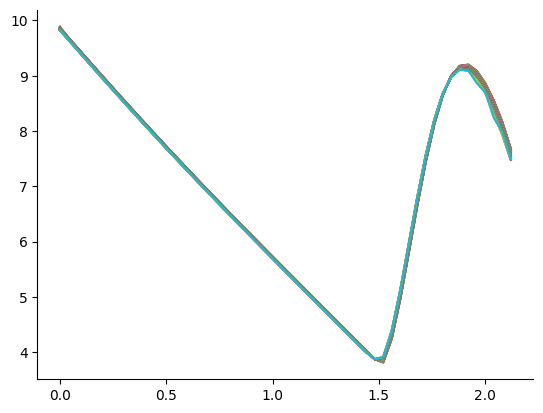

In [15]:
plt.plot(y1_grid_cap, ems)
plt.show()

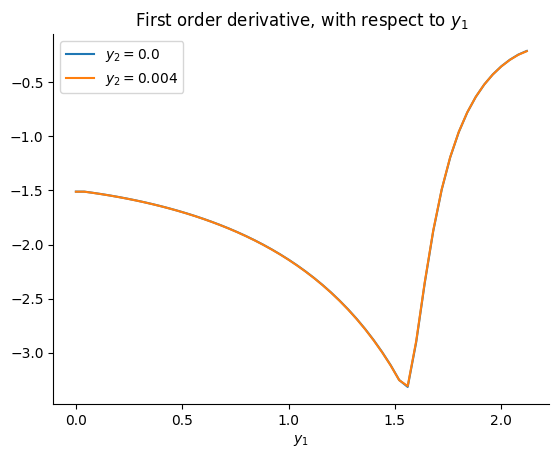

In [16]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

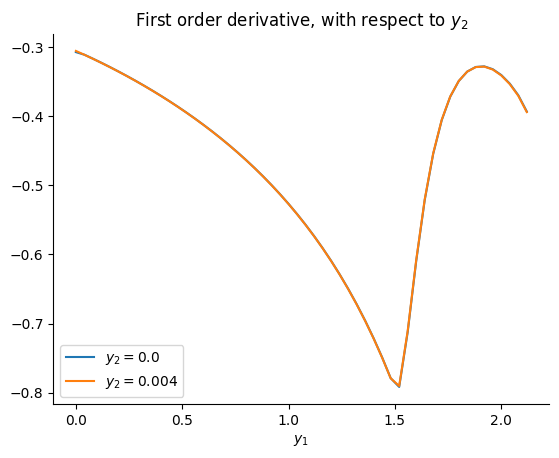

In [17]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

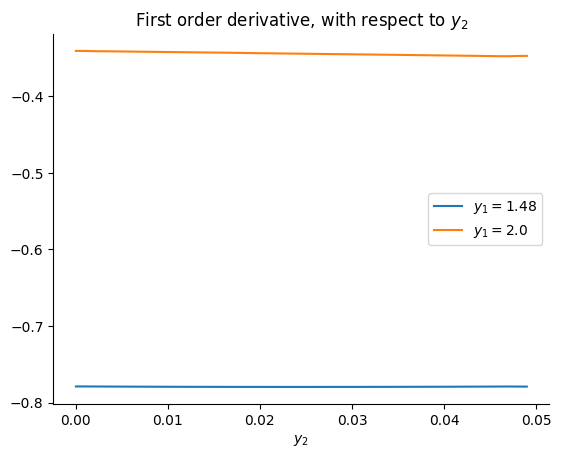

In [18]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

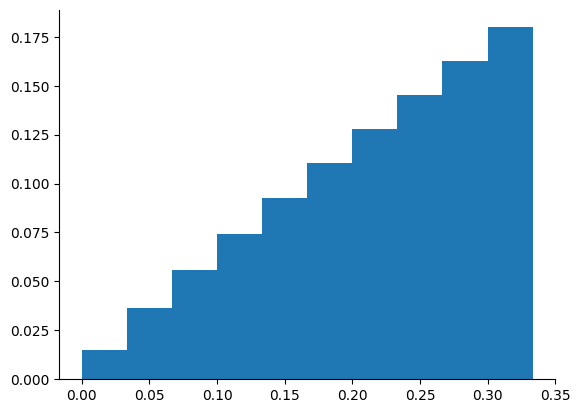

In [19]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

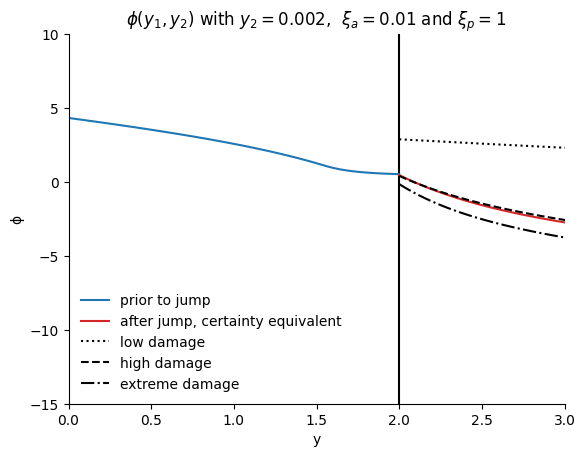

In [20]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

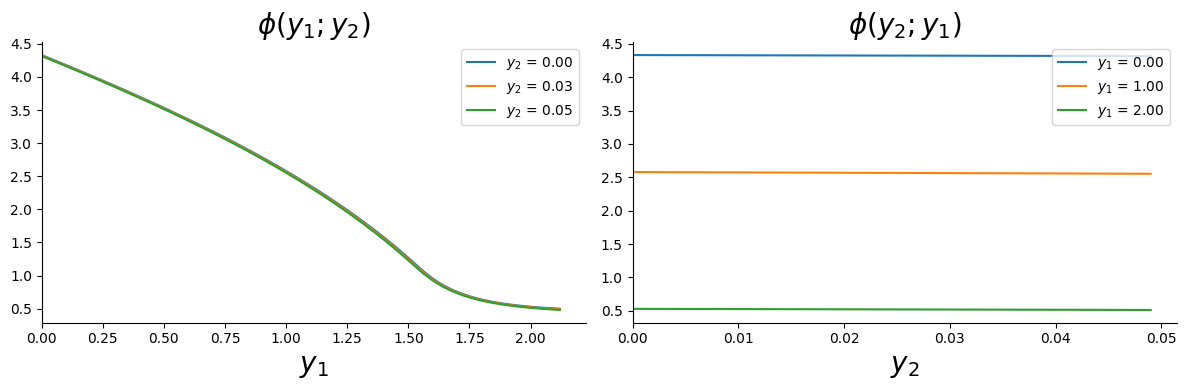

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

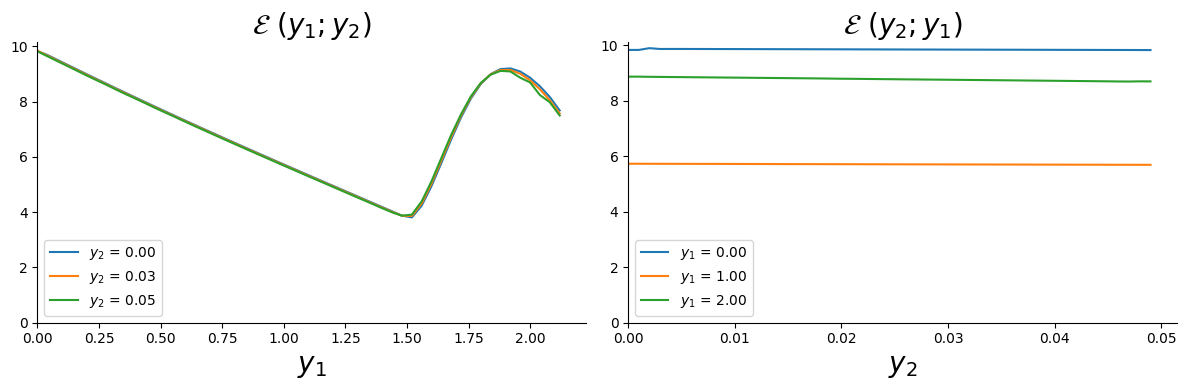

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [23]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [24]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [25]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [26]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [27]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

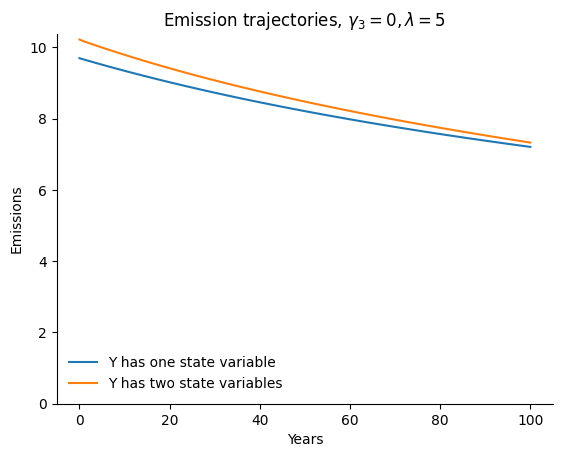

In [29]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [30]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=89
                                                 )

In [31]:
y1t_prejump

array([1.1       , 1.10988554, 1.11974267, 1.12952919, 1.13924547,
       1.14889203, 1.15846936, 1.16797796, 1.1774184 , 1.18679117,
       1.19609677, 1.20533567, 1.21450841, 1.22361548, 1.23265736,
       1.24163452, 1.2505474 , 1.2593965 , 1.26818226, 1.27690514,
       1.28556558, 1.29416404, 1.30270096, 1.31117676, 1.3195919 ,
       1.32794681, 1.33624191, 1.34447764, 1.35265441, 1.36077264,
       1.36883275, 1.37683511, 1.38478013, 1.39266821, 1.40049977,
       1.4082752 , 1.41599489, 1.42365923, 1.43126861, 1.43882344,
       1.44632409, 1.45377185, 1.46116723, 1.46851059, 1.47580225,
       1.48304257, 1.49024643, 1.497434  , 1.50460544, 1.51176077,
       1.51889998, 1.5260231 , 1.53326384, 1.54065044, 1.54818623,
       1.55587433, 1.56371792, 1.57176906, 1.58008948, 1.58868898,
       1.59757705, 1.6067635 , 1.61629607, 1.62620228, 1.63649693,
       1.64719528, 1.65831811, 1.66988482, 1.68191299, 1.69441528,
       1.70737967, 1.7208225 , 1.73475654, 1.74912688, 1.76394

In [32]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

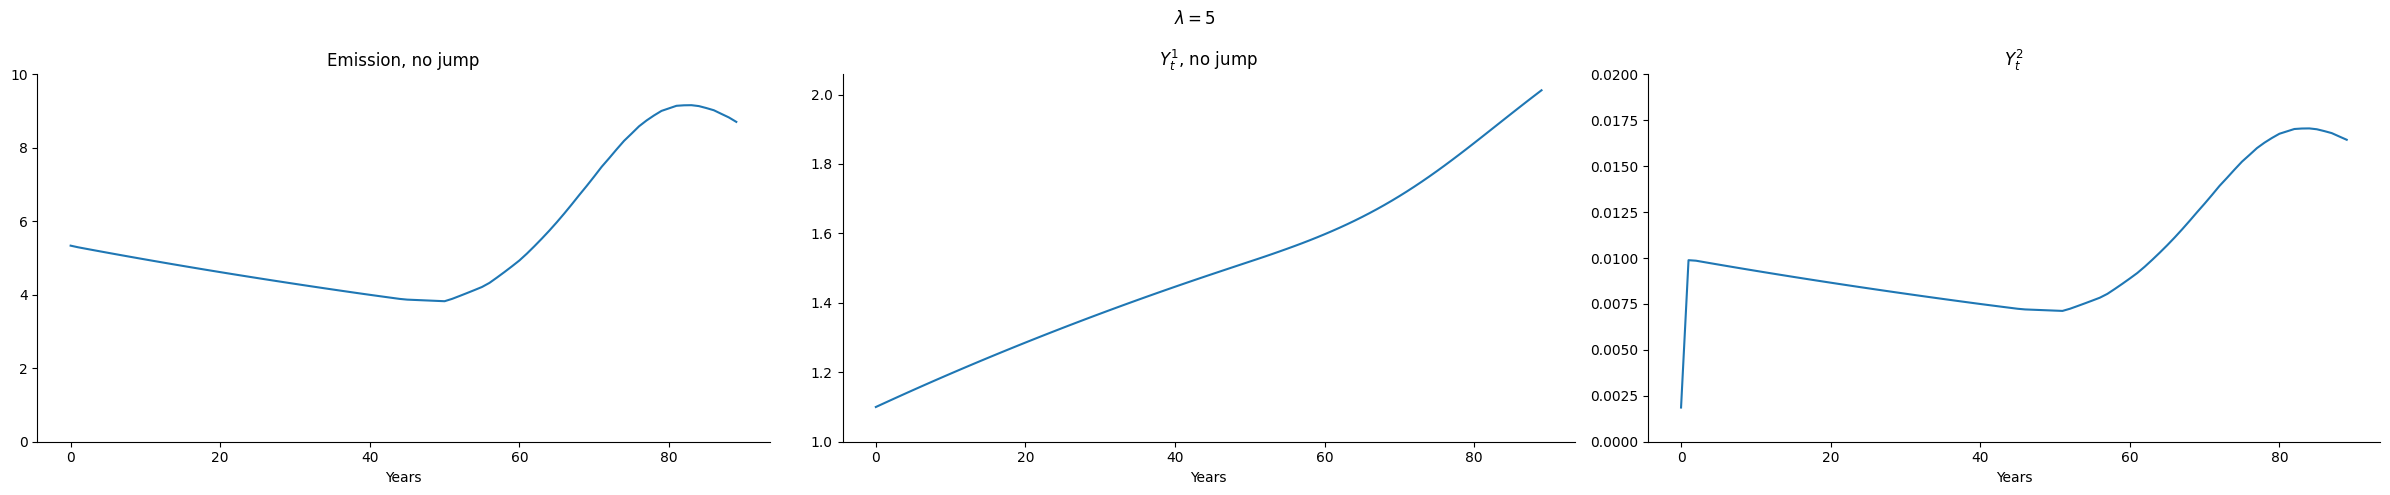

In [50]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [51]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

In [52]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.017060811385774376,
 0.049,
 array([1.1       , 1.10988554, 1.11974267, 1.12952919, 1.13924547,
        1.14889203, 1.15846936, 1.16797796, 1.1774184 , 1.18679117,
        1.19609677, 1.20533567, 1.21450841, 1.22361548, 1.23265736,
        1.24163452, 1.2505474 , 1.2593965 , 1.26818226, 1.27690514,
        1.28556558, 1.29416404, 1.30270096, 1.31117676, 1.3195919 ,
        1.32794681, 1.33624191, 1.34447764, 1.35265441, 1.36077264,
        1.36883275, 1.37683511, 1.38478013, 1.39266821, 1.40049977,
        1.4082752 , 1.41599489, 1.42365923, 1.43126861, 1.43882344,
        1.44632409, 1.45377185, 1.46116723, 1.46851059, 1.47580225,
        1.48304257, 1.49024643, 1.497434  , 1.50460544, 1.51176077,
        1.51889998, 1.5260231 , 1.53326384, 1.54065044, 1.54818623,
        1.55587433, 1.56371792, 1.57176906, 1.58008948, 1.58868898,
        1.59757705, 1.6067635 , 1.61629607, 1.62620228, 1.63649693,
        1.64719528, 1.65831811, 1.66988482, 1.68191299, 1.69441528,
        1.7073796

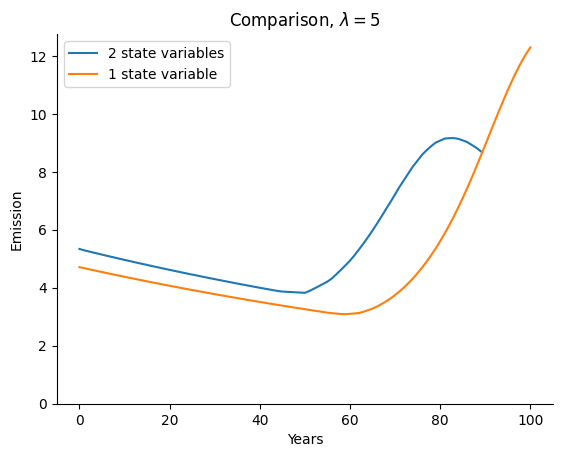

In [54]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [55]:

# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [56]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [58]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=90)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

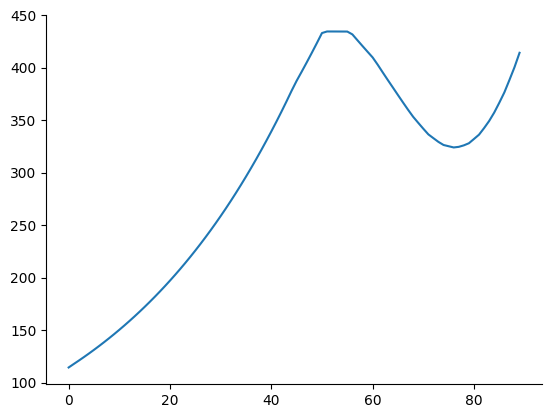

In [59]:
plt.plot(scc)
plt.show()

In [60]:
np.save(f"scct_{λ}", scc)